# The Personal Attributes of A Patient that Influences One's Medical Costs

## Introduction

With the development of society and the advancement in medicine technology, people become more concerned about their personal health and are willing to spent more money on their health insurance. These medical costs may be affected by factors such as age, sex, and etc. The project proposes, out of our interest, to build a model of some number of input variables which accurately predicts the response variable, medical costs. Formally our question is:

*What features would most accurately predict the medical costs, and what are the effects of those attributes?*

Out of interest in and to assess this topic, our group has selected a simulated dataset on the basis of demographic statistics from the US census bureau. The dataset presents a variety of attributes such as one response variable, “charges”; and six explanatory variables, which are “age”, “sex”, “bmi”(Body mass index), “children”, “smoker”, and “region”, repectively.

## Preliminary Results

### Importing Modules

In [1]:
library(latex2exp)
library(repr)
library(digest)
library(gridExtra)
library(mltools)
library(cowplot)
library(infer)
library(AER)
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(dplyr)))
suppressWarnings(suppressMessages(library(broom)))
suppressWarnings(suppressMessages(library(GGally)))
suppressWarnings(suppressMessages(library(leaps)))
suppressWarnings(suppressMessages(library(glmnet)))
suppressWarnings(suppressMessages(library(faraway)))
suppressWarnings(suppressMessages(library(base)))

Loading required package: car

Loading required package: carData

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival



### Downloading Dataset

In [2]:
insurance <- read_csv("https://raw.githubusercontent.com/LukeXboy/STAT-301-Group-Project/main/insurance.csv")
head(insurance)

Rows: 1338 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (4): age, bmi, children, charges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age sex    bmi    children smoker region    charges  
1 19  female 27.900 0        yes    southwest 16884.924
2 18  male   33.770 1        no     southeast  1725.552
3 28  male   33.000 3        no     southeast  4449.462
4 33  male   22.705 0        no     northwest 21984.471
5 32  male   28.880 0        no     northwest  3866.855
6 31  female 25.740 0        no     southeast  3756.622

*Table 1.1: Preview of Orginial Insurance Dataset*

### Feature Descriptions and Wrangling the Dataset

We look into the features of the dataset to see if we can wrangle the raw data into more comprehensable and useable forms.

The dataset contains the following variables relating to the patient:
- age
- sex
- bmi: Represents the Body Mass Index
- children: Number of children or dependents covered by the health insurance
- smoker: If the patient is a smoker
- region: Beneficiary's residentual area in the United States of America
- charges: Individual medical costs billed by the health insurance company **(response)**

In [3]:
#Produces further information about the feature values within the dataset
summary(insurance)

      age            sex                 bmi           children    
 Min.   :18.00   Length:1338        Min.   :15.96   Min.   :0.000  
 1st Qu.:27.00   Class :character   1st Qu.:26.30   1st Qu.:0.000  
 Median :39.00   Mode  :character   Median :30.40   Median :1.000  
 Mean   :39.21                      Mean   :30.66   Mean   :1.095  
 3rd Qu.:51.00                      3rd Qu.:34.69   3rd Qu.:2.000  
 Max.   :64.00                      Max.   :53.13   Max.   :5.000  
    smoker             region             charges     
 Length:1338        Length:1338        Min.   : 1122  
 Class :character   Class :character   1st Qu.: 4740  
 Mode  :character   Mode  :character   Median : 9382  
                                       Mean   :13270  
                                       3rd Qu.:16640  
                                       Max.   :63770  

Table 1.1 and the summary results suggests that some of the variables in the dataset could be better represented as categorical variables for the purposes of our proposal; thus, we apply the changes for the feature values of sex, smoker, and region variables.

In [4]:
#Combining similar levels of region for future feature selection
insurance_factor <- insurance %>%
    mutate(region = ifelse(insurance$region == "northwest" | insurance$region == "northeast", "north", "south"))
head(insurance_factor)

#Mutating the features to be categorical variables for further analysis
insurance_factor <- insurance_factor %>%
    mutate(sex = as.factor(sex)) %>%
    mutate(smoker = as.factor(smoker)) %>%
    mutate(region = as.factor(region)) 

#To check the feature values after mutating the variables
summary(insurance_factor)

age sex    bmi    children smoker region charges  
1 19  female 27.900 0        yes    south  16884.924
2 18  male   33.770 1        no     south   1725.552
3 28  male   33.000 3        no     south   4449.462
4 33  male   22.705 0        no     north  21984.471
5 32  male   28.880 0        no     north   3866.855
6 31  female 25.740 0        no     south   3756.622

      age            sex           bmi           children     smoker    
 Min.   :18.00   female:662   Min.   :15.96   Min.   :0.000   no :1064  
 1st Qu.:27.00   male  :676   1st Qu.:26.30   1st Qu.:0.000   yes: 274  
 Median :39.00                Median :30.40   Median :1.000             
 Mean   :39.21                Mean   :30.66   Mean   :1.095             
 3rd Qu.:51.00                3rd Qu.:34.69   3rd Qu.:2.000             
 Max.   :64.00                Max.   :53.13   Max.   :5.000             
   region       charges     
 north:649   Min.   : 1122  
 south:689   1st Qu.: 4740  
             Median : 9382  
             Mean   :13270  
             3rd Qu.:16640  
             Max.   :63770  

*Table 1.2 (top): Preview of Insurance Dataset with Mutated Categorical Variables*

Through Table 1.2, it is clear that there are discrete values or levels for these variables. We confirm our speculations and implement the changes of wrangling the data set by mutating the variables to be categorical.

In [5]:
#Implementing changes
insurance <- insurance_factor

#Printing number of rows related to the database
cat("Number of instances in the insurance dataset: ", nrow(insurance), "\n")
cat("Number of instances with missing values in the dataset: ", sum(is.na(insurance)), "\n")

Number of instances in the insurance dataset:  1338 
Number of instances with missing values in the dataset:  0 


Our dataset is now wrangled to accurately represent our data and contains no missing values, and ready to be split into the training and testing sets.

### Variable Distributions and Correlations

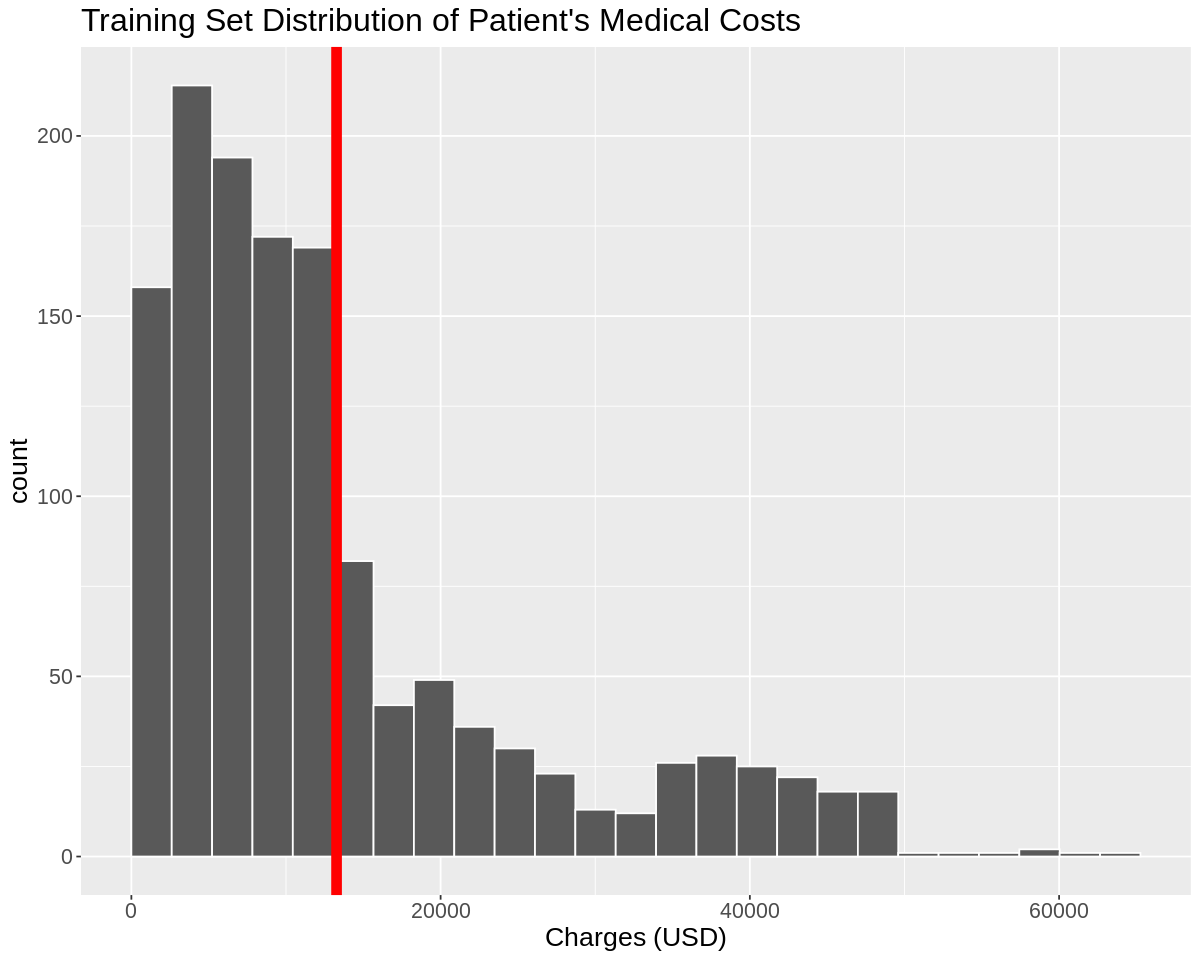

In [6]:
#Historgram to visualize response variable's, charges, distribution
options(repr.plot.width = 10, repr.plot.height = 8)
charges_hist <- insurance %>%
    ggplot(aes(x = charges)) + 
    geom_histogram(bins = 25, boundary = 0, colour = 'white') +
    labs(title = "Training Set Distribution of Patient's Medical Costs", 
         x = "Charges (USD)") +
    theme(text = element_text(size = 16)) +
    geom_vline(xintercept = mean(insurance$charges), colour = 'red', size = 3) 
charges_hist

*Figure 1.1: Histogram Displaying Training Set Distribution of Response Variable within Training , Charges, which represents the Medical Costs of the Patient. The Red Vertical Line Indicates the Variable Mean. We notice that Charges has a Left-skewed Distribution.*

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



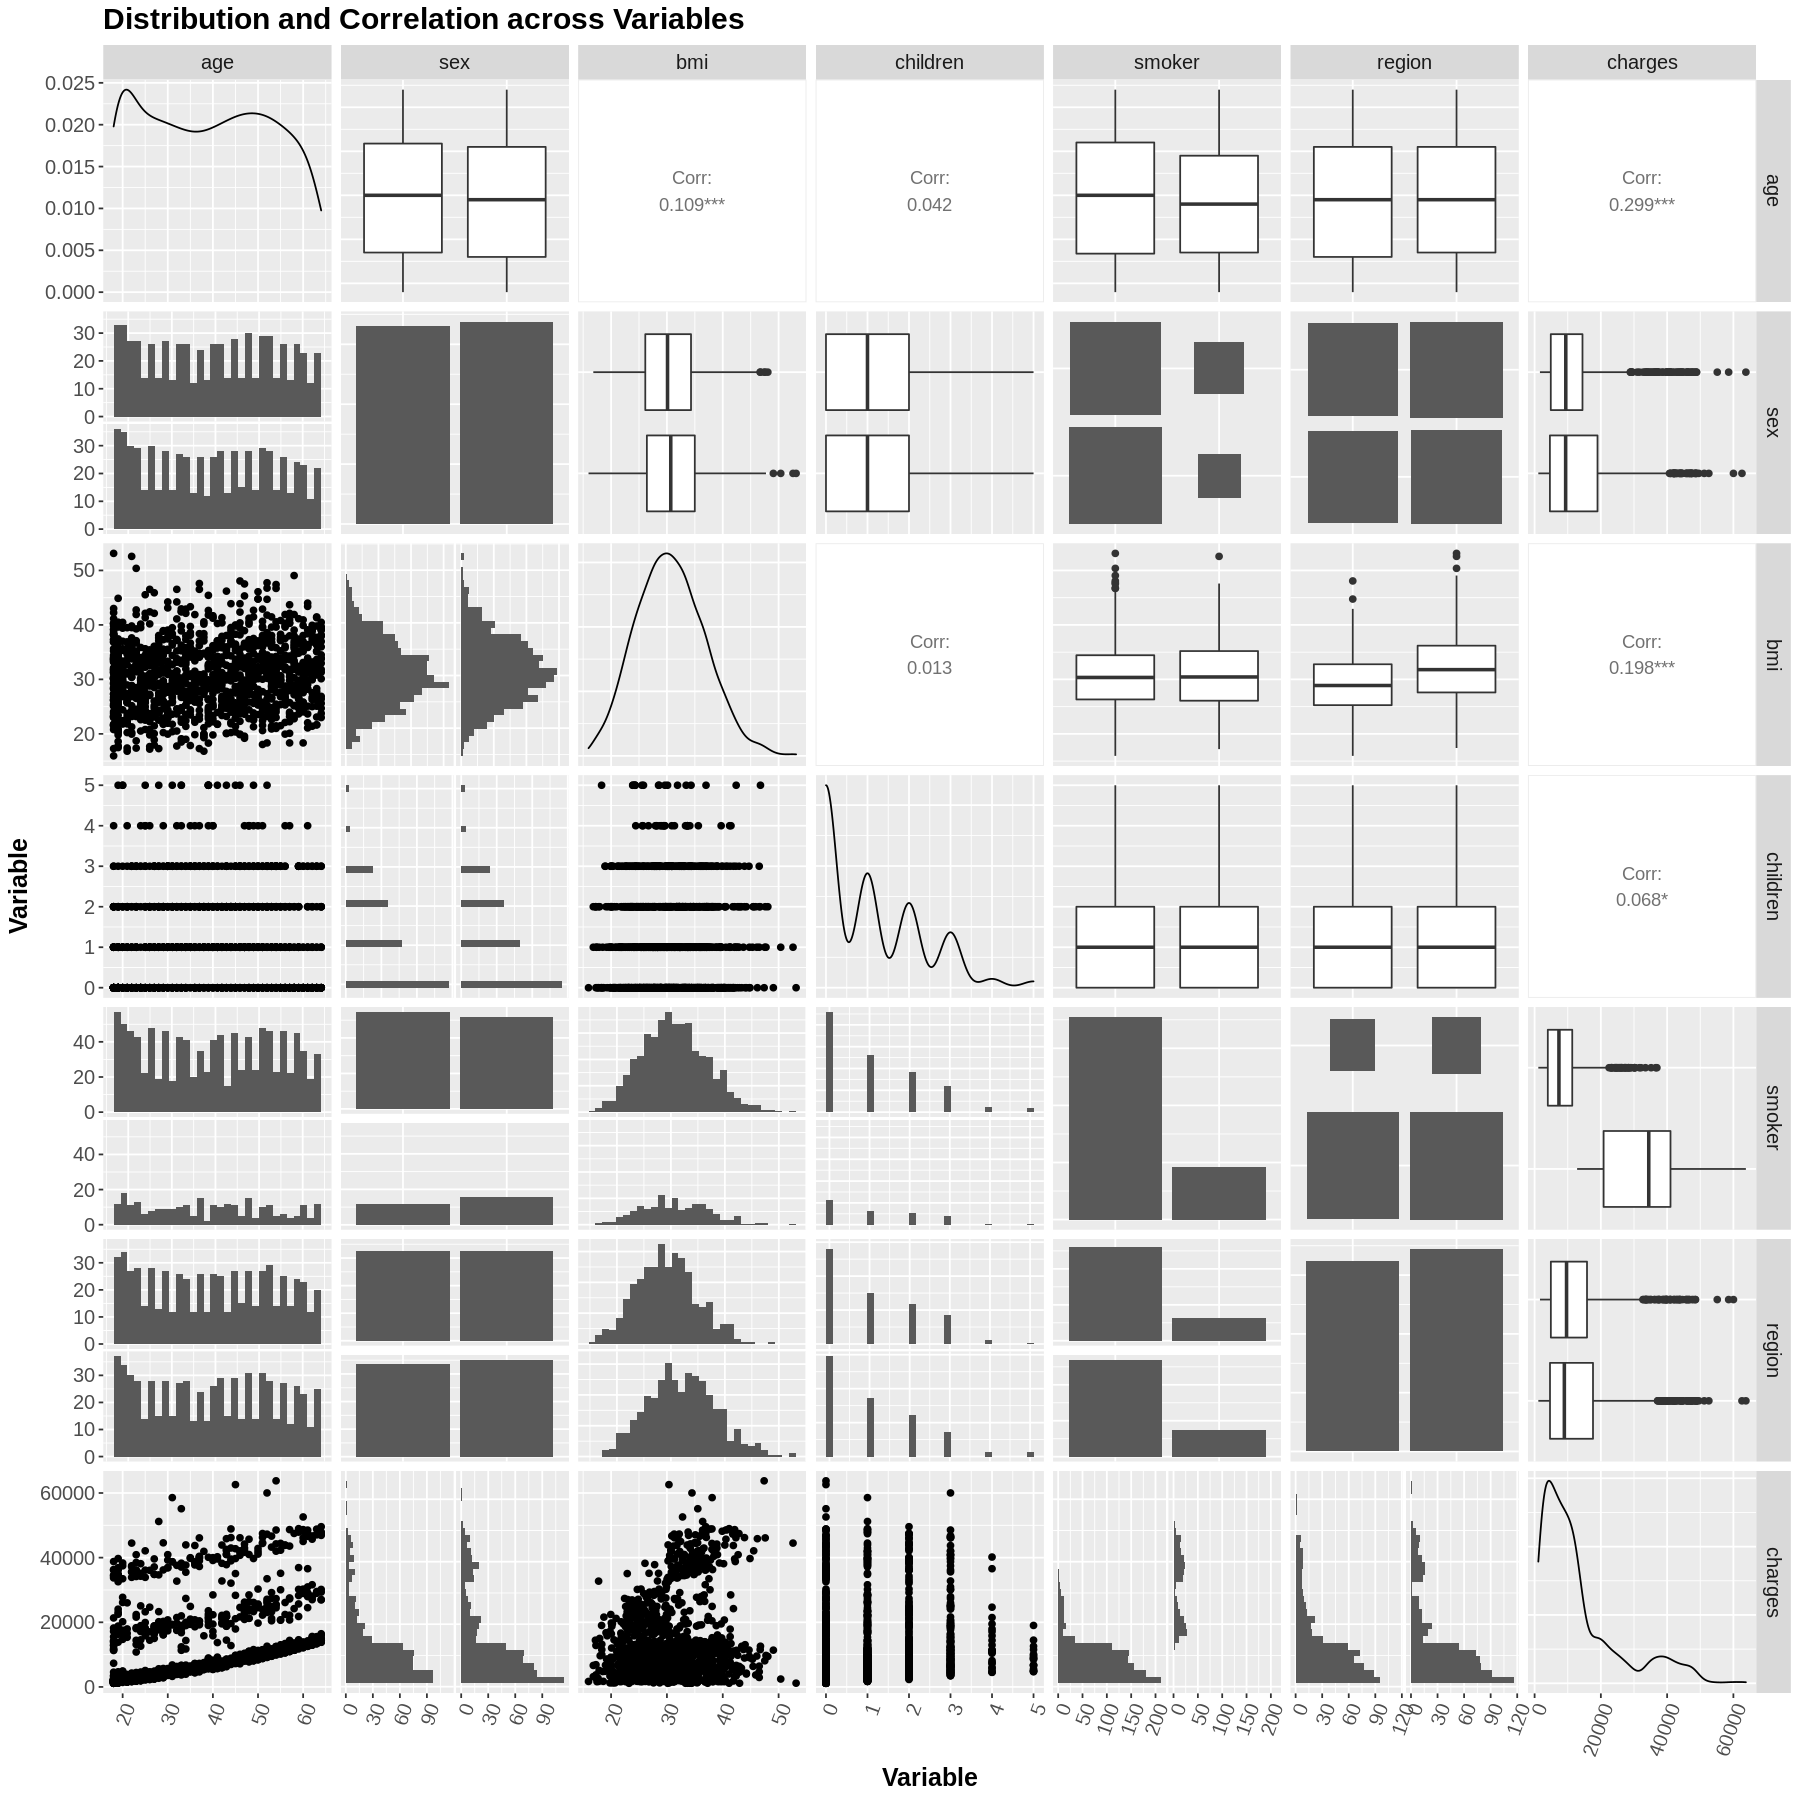

In [7]:
#Comparing correlation across all variables with a GGPairs plot
options(repr.plot.width = 15, repr.plot.height = 15)
all_corr_plot <- insurance %>%
    ggpairs() +
  labs(title = "Distribution and Correlation across Variables",
       x = "Variable",
       y = "Variable") +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 70, vjust = 1, hjust=1) #To ensure labels do not overlap
  )
all_corr_plot

*Figure 1.2: Distribution and Correlations Across Variables in the Dataset.*

### Splitting Data into Training and Testing Sets

In [8]:
#Splitting the data by labelling the data by ID
set.seed(123456)
insurance$ID <- rownames(insurance)
insurance_training <- sample_n(insurance, size = nrow(insurance) * 0.70, replace = FALSE)
insurance_testing <- anti_join(insurance, insurance_training, by = "ID")

insurance_training <- select(insurance_training, -ID)
insurance_testing <- select(insurance_testing, -ID)

head(insurance_training)
head(insurance_testing)

age sex    bmi   children smoker region charges  
1 32  male   31.50 1        no     south   4076.497
2 59  male   27.50 1        no     south  12333.828
3 42  female 25.30 1        no     south   7045.499
4 42  male   34.10 0        no     south   5979.731
5 18  male   35.20 1        no     south   1727.540
6 18  female 26.73 0        no     south   1615.767

age sex    bmi    children smoker region charges  
1 19  female 27.900 0        yes    south  16884.924
2 32  male   28.880 0        no     north   3866.855
3 37  female 27.740 3        no     north   7281.506
4 60  female 25.840 0        no     north  28923.137
5 23  male   23.845 0        no     north   2395.172
6 63  female 23.085 0        no     north  14451.835

*Table 1.3 (top): Preview of the training set of the dataset* 

*Table 1.3 (bottom): Preview of the testing set of the dataset*

In [9]:
#Printing number of rows within split dataset
cat("Number of instances in the training set: ", nrow(insurance_training), "\n")
cat("Number of instances in the testing set: ", nrow(insurance_testing), "\n")

Number of instances in the training set:  936 
Number of instances in the testing set:  402 


We split the dataset into a training and testing set as our project proposes to produce a predictive model which predicts charges on the new observations of patients. 

## Methods: Plan

The dataset is reliable as it produced or simulated for the purposes of prediction, and it is helpful as it contains a variety of variables of different types and ranges, as deduced from the distribution of variables against charges (Figure 1.5). Through the brief analysis of the continous variables in the dataset, the dataset provides to be additionally helpful as it is suggest that the dataset contains no multicollinearity (Figure 1.6); however, this would be further confirmed through computing Variance Inflation Factors in the project.

The proposed project plans to build a predictive multilinear regression model, through either forward or backwards feature selection where values such as the Cp and BIC are minimized. Moreover the effect between the input variables will be analyzed through additionally comparing the additive model and model with interactions. To select the model which best fits and predicts the data, F-test and RMSE will be compared between models. 

We expect to build a MLR model which accurately predicts a patient's medical costs given some inputs of a patients personal information. 

Hopefully our project hopes to impact the greater society as our results could help medical organizations or particular government departments decide on their financial assignment. 

**to do:**
- describe why the data was split
- reliability
- results from ggpairs
- plans for feature selection, where minimizing - values
- results from ggpairs provided slight insight into correlation and confounding variables, will check for heteroscedasticity and normal errors
- build an MLR off the feature selection and evaluate the effect between using interaction terms and not using interactions
- evaluated models based off RMSE
- find the best model. 

## Results

### Estimating Multilinear Regression Model

In [10]:
#Estimate additive MLR model using all variables in the dataset
insurance_full_MLR <- lm(charges ~ ., data = insurance_training)
tidy(insurance_full_MLR)

term        estimate    std.error  statistic  p.value      
1 (Intercept) -10653.6330 1151.96202 -9.2482502  1.524723e-19
2 age            241.0604   14.44958 16.6828650  7.448097e-55
3 sexmale       -313.8132  402.86313 -0.7789573  4.362032e-01
4 bmi            317.5317   33.42351  9.5002491  1.719942e-20
5 children       513.3964  168.26007  3.0512073  2.343990e-03
6 smokeryes    23962.2000  504.52291 47.4947711 9.059586e-251
7 regionsouth  -1004.6347  412.39565 -2.4360943  1.503383e-02

In [11]:
#Obtaining out-of-sample predictions for training set
insurance_test_pred_full_MLR <- predict(insurance_full_MLR, newdata = insurance_testing)
head(insurance_test_pred_full_MLR)

1         2         3         4         5         6 
25743.214  5916.802  8614.120 12015.010  2148.486 11863.392

In [12]:
#Storing model evaluations
insurance_RMSE_models <- tibble(
    Model = "Full Additive Regression",
    R_MSE = rmse(
        preds = insurance_test_pred_full_MLR,
        actuals = insurance_testing$charges)
    )
insurance_RMSE_models

Model                    R_MSE   
1 Full Additive Regression 5888.656

### Mutlicollinearity

In [31]:
#Check if there is multicollinearity within the dataset using Variance Inflation Factors
vif_insurance <- vif(insurance_full_MLR)
round(vif_insurance, 3)

age     sexmale         bmi    children   smokeryes regionsouth 
      1.014       1.006       1.062       1.002       1.005       1.051

**to add**
- In combination of VIFS and the correlation and distribution charts of Figure 1.2 -> no multicollinearity

### A Smaller Model using Forward Selection

In [20]:
#Using the forward selection algorithm to find a reduced LR model
insurance_forward_sel <- regsubsets(
    x = charges ~ ., nvmax = 6, 
    data = insurance_training,
    method = "forward",
    )

insurance_forward_summary <- summary(insurance_forward_sel)
insurance_forward_summary

Subset selection object
Call: regsubsets.formula(x = charges ~ ., nvmax = 6, data = insurance_training, 
    method = "forward", )
6 Variables  (and intercept)
            Forced in Forced out
age             FALSE      FALSE
sexmale         FALSE      FALSE
bmi             FALSE      FALSE
children        FALSE      FALSE
smokeryes       FALSE      FALSE
regionsouth     FALSE      FALSE
1 subsets of each size up to 6
Selection Algorithm: forward
         age sexmale bmi children smokeryes regionsouth
1  ( 1 ) " " " "     " " " "      "*"       " "        
2  ( 1 ) "*" " "     " " " "      "*"       " "        
3  ( 1 ) "*" " "     "*" " "      "*"       " "        
4  ( 1 ) "*" " "     "*" "*"      "*"       " "        
5  ( 1 ) "*" " "     "*" "*"      "*"       "*"        
6  ( 1 ) "*" "*"     "*" "*"      "*"       "*"        

In [22]:
#Summary table of measures for all forward selection models
insurance_forward_summary_df <- tibble(
    n_input_variables = 1:6,
    ADJ.R2 = insurance_forward_summary$adjr2,
    BIC = insurance_forward_summary$bic,
    Cp = insurance_forward_summary$cp
    )
insurance_forward_summary_df

n_input_variables ADJ.R2    BIC        Cp        
1 1                 0.6233669  -901.3072 418.680882
2 2                 0.7130275 -1149.9528  98.038270
3 3                 0.7359263 -1221.9509  16.992655
4 4                 0.7382926 -1224.5390   9.520146
5 5                 0.7396672 -1223.6326   5.606774
6 6                 0.7395570 -1217.4021   7.000000

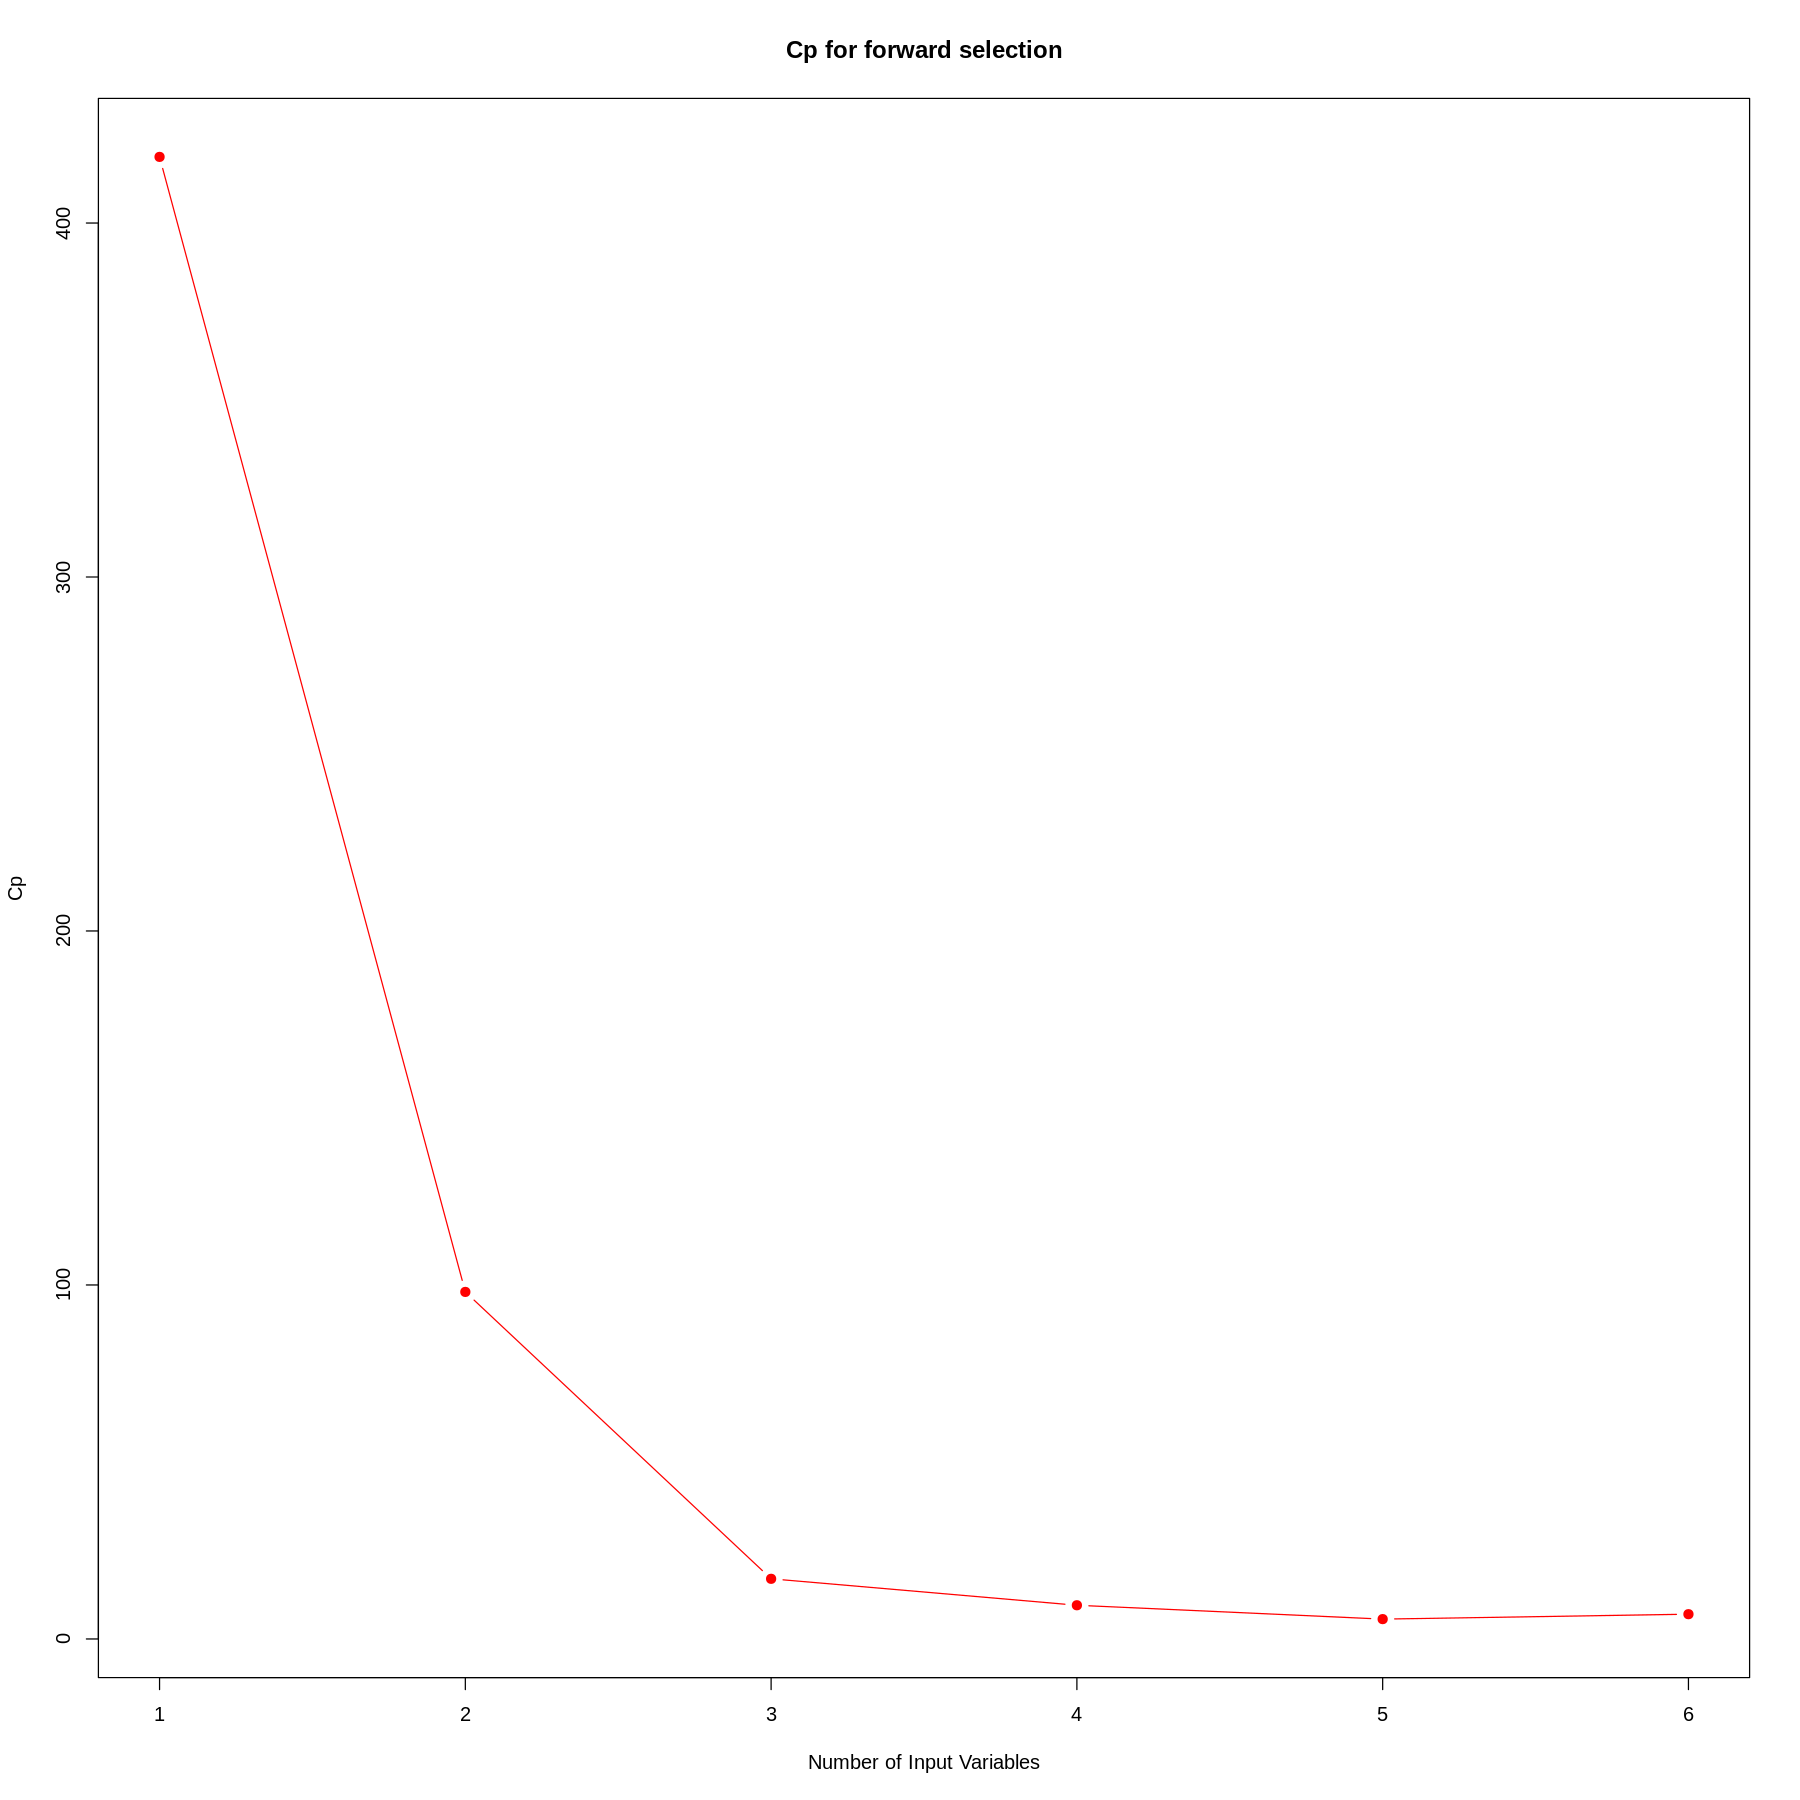

In [23]:
#Illustrates Cp of forward selection models
plot(summary(insurance_forward_sel)$cp,
  main = "Cp for forward selection",
  xlab = "Number of Input Variables", ylab = "Cp", type = "b", pch = 19,
  col = "red"
)

**to do**
- Selected model is one with 5 inputs.

In [25]:
# Estimation
insurance_reduced_MLR <- lm(charges ~ age + bmi + children + smoker + region, data = insurance_training
)

# Prediction
insurance_test_pred_reduced_MLR <- predict(insurance_reduced_MLR, newdata = insurance_testing)
head(insurance_test_pred_reduced_MLR)

1         2         3         4         5         6 
25560.916  6075.994  8459.588 11871.387  2309.219 11722.998

In [27]:
insurance_RMSE_models <- rbind(
    insurance_RMSE_models,
    tibble(
    Model = "Reduced Forward Selection Additive Regreesion",
    R_MSE = rmse(
        preds = insurance_test_pred_reduced_MLR,
        actuals = insurance_testing$charges)
    )
    )
insurance_RMSE_models

Model                                         R_MSE   
1 Full Additive Regression                      5888.656
2 Reduced Forward Selection Additive Regreesion 5882.354

### Effect of Interaction Terms

In [29]:
#Estimation
insurance_reduced_int_MLR <- lm(charges ~ age * bmi * children * smoker * region, data = insurance_training
)

# Prediction
insurance_test_pred_reduced_int_MLR <- predict(insurance_reduced_int_MLR, newdata = insurance_testing)
head(insurance_test_pred_reduced_int_MLR)

1         2         3         4         5         6 
23301.620  6229.837  9826.211 13174.103  3869.737 13830.574

In [30]:
insurance_RMSE_models <- rbind(
    insurance_RMSE_models,
    tibble(
    Model = "Reduced Forward Selection Regression with Interactions",
    R_MSE = rmse(
        preds = insurance_test_pred_reduced_int_MLR,
        actuals = insurance_testing$charges)
    )
    )
insurance_RMSE_models

Model                                                  R_MSE   
1 Full Additive Regression                               5888.656
2 Reduced Forward Selection Additive Regreesion          5882.354
3 Reduced Forward Selection Regression with Interactions 4854.012

## Methods: Results

## Discussion

## References

Huang, J. Z. (2014). An introduction to statistical learning: With applications in R by gareth james, trevor hastie, robert tibshirani, daniela witten. Journal of Agricultural, Biological, and Environmental Statistics, 19(4), 419. https://doi.org/10.1007/s13253-014-0179-9

Lantz, B., & O'Reilly for Higher Education. (2015). Machine learning with R: Discover how to build machine learning algorithms, prepare data, and dig deep into data prediction techniques with R. Packt Publishing.


**Word Count:** 537